---
title: "Machine Learning Notes IV: Logistic Regression"
author: "Alejandro Pérez Sanjuán"
date: 2024-08-20
categories: [machine learning, python, logistic regression]
format: html
image: "thumbnails/ml_4.png"
---

Personal notes for myself about logistic regression and how to implement it from scratch using gradient descent.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.base import ClassifierMixin
from scipy.special import expit

## 1. Introduction

Despite its name, logistic regression is a classification algorithm. The regression term from the name comes from the fact that the algorithm is just a linear regression passed through a logits function, commonly known as *sigmoid* function. Let's put this into mathematical terms.

$$
\hat{Y} = \sigma(Z) = \sigma \left( \dfrac{1}{1 + e^{-X B}} \right).
$$

Here, $X$ is a matrix of shape $(n, p+1)$, where $p$ are the number of features and $n$ the number of samples. The extra 1 accounts for the intercept. Consequently, $B$ is a column-vector of shape $(p+1, 1)$ of parameters to optimize. The term $Z=XB$ is the linear regression. Refer to [this post](https://xylambda.github.io/qblog/posts/17_08_2024_ml_notes_3.html) for more in deepth information.

The loss function we use for this algorithm is the binary cross-entropy, defined in matrix form as

$$
L(\hat{Y}) = - \dfrac{1}{n} \left[ Y \cdot log(\hat{Y}) +  (1 - Y) \cdot log(1- \hat{Y}) \right]
$$

### 1.1. Gradient descent solution

Unfortunately, there is no closed-form solution for estimating the $B$ parameters in the case of logistic regression, but we can approach the problem using iterative methods such as gradient descent.

Note that the loss function $L$ is a composition of functions such that $L(\hat{Y} (Z (B)))$. To compute the gradient of the loss function we can simply apply the chain rule

$$
\dfrac{\partial L}{\partial B} = \dfrac{\partial L}{\partial \hat{Y}} \cdot \dfrac{\partial \hat{Y}}{\partial Z} \cdot \dfrac{\partial Z}{\partial B},
$$

and then derive each term on its own. Let us start by the first term $\dfrac{\partial L}{\partial \hat{Y}}$. We have to apply the product rule of derivatives to each one of the terms in the loss function

$$
\dfrac{\partial L}{\partial \hat{Y}} = - \left[ \dfrac{Y}{\hat{Y}} + (1 - Y) \cdot \dfrac{1}{1 - \hat{Y}} \cdot (-1) \right].
$$

Then, we just expand the terms and reduce

$$
\dfrac{\partial L}{\partial \hat{Y}} = \dfrac{\hat{Y} - Y}{\hat{Y} (1 - \hat{Y})}.
$$

The next term is the derivative of $\hat{Y}$ with respect to $Z$. Remember $\hat{Y}$ is the results of applying the sigmoid function element-wise to $Z$, and so this derivative is the derivative of the sigmoid function:

$$
\dfrac{\partial \hat{Y}}{\partial Z} = \sigma(Z) \cdot (1 - \sigma(Z)) = \hat{Y} (1 - \hat{Y}).
$$

Lastly, the derivative of $Z$ with respect to the coefficients vector $B$ is trivial

$$
\dfrac{\partial Z}{\partial B} = X.
$$

Putting everything together we have

$$
\dfrac{\partial L}{\partial B} = X^{T} \left[ \dfrac{\hat{Y} - Y}{\hat{Y} (1 - \hat{Y})} \cdot \hat{Y} (1 - \hat{Y}) \right] = X^{T} (\hat{Y} - Y).
$$

Notice how the $X$ matrix has been transposed to make sense of the product operation. The final gradient of the binary cross-entropy loss then becomes

$$
\nabla L(B) = \dfrac{1}{n} \cdot X^{T} (\hat{Y} - Y).
$$

### 1.1. Multiclass classification

We won't dive into the multiclass problem, but note that we only need to change the sigmoid function for the softmax function and use the general version of the binary cross-entropy problem, called cross-entropy problem.

## 2. Coding logistic regression from scratch

In [2]:
class LogisticRegression(ClassifierMixin):
    """Gradient descent logistic regression.

    Estimates the parameters using a gradient descent optimization
    approach.
    
    Parameters
    ----------
    l_rate : float, optional, default: 1e-3
        Learning rate.
    batch_size : int, optional, default: 1
        Batch size for the gradient descent algorithm. 1 will perform
        a stochastic gradient descent.
    fit_intercept : bool, optional, default: True
        Whether to add the intercept or not to the regression.
    n_epochs : int, optional, default: 1000
        Number of epochs for the training.
    epsilon : float, optional, default: 1e-8
        Epsilon for the loss function to avoid divisions by zero.
    reduce : str, optional, default: "sum", {"sum", "mean"}
        Function to reduce the loss.
    """
    def __init__(
        self,
        l_rate=1e-3,
        batch_size=1,
        fit_intercept=True,
        n_epochs=1_000,
        epsilon=1e-8,
        reduce="sum",
    ):
        self.l_rate = l_rate
        self.batch_size = batch_size
        self.fit_intercept = fit_intercept
        self.n_epochs = n_epochs
        self.epsilon = epsilon
        self.reduce = reduce

        # attributes
        self.coefficients_ = None
        self.loss = []

    def _binary_cross_entropy_loss(self, y_true, y_est, batch_size):
        epsilon = self.epsilon
        y_class_0 = y_true * np.log(y_true + epsilon)
        y_class_1 = (1 - y_true) * np.log(1 - y_est + epsilon)

        if self.reduce == "mean":
            return -(1 / batch_size) * (y_class_0 + y_class_1).mean()
        elif self.reduce == "sum":
            return -(1 / batch_size) * (y_class_0 + y_class_1).sum()
        else:
            raise ValueError(f"Unsupported value for 'reduce': {self.reduce}")

    def fit(self, X, y):
        n_samples, n_features = X.shape
        n_epochs = self.n_epochs
        fit_intercept = self.fit_intercept
        l_rate = self.l_rate
        batch_size = self.batch_size
        
        if fit_intercept:
            X = np.hstack((np.ones((n_samples, 1)), X))

        coefficients_ = np.zeros(X.shape[1])

        for _ in range(n_epochs):
            for i in range(0, n_samples, batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]

                # make prediction
                prediction = expit(X_batch @ coefficients_)

                # compute loss
                _loss = self._binary_cross_entropy_loss(
                    y_batch, prediction, batch_size=batch_size
                )
                self.loss.append(_loss)

                # compute gradient
                gradient = (1 / batch_size) * X_batch.T @ (prediction - y_batch)

                # update parameters
                coefficients_ -= l_rate * gradient

        self.coefficients_ = coefficients_

    def predict(self, X, threshold=0.5):
        if self.fit_intercept:
            X = np.hstack((np.ones((X.shape[0], 1)), X))

        probs = expit(X @ self.coefficients_)
        y_pred = np.where(probs < threshold, 0, 1)
        return y_pred

    def predict_proba(self, X):
        if self.fit_intercept:
            X = np.hstack((np.ones((X.shape[0], 1)), X))

        return expit(X @ self.coefficients_)

As with the previous posts, we generate a synthetic dataset using Scikit-Learn.

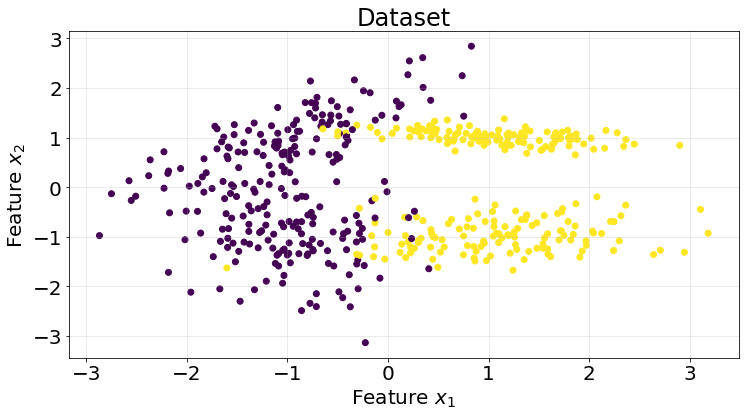

In [3]:
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_classes=2, random_state=10)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.scatter(X[:, 0], X[:, 1], c=y)
ax.grid(True, alpha=.3)
ax.set_title("Dataset", fontsize=24)
ax.set_xlabel("Feature $x_{1}$", fontsize=20)
ax.set_ylabel("Feature $x_{2}$", fontsize=20)
ax.tick_params(labelsize=20)

In [4]:
kf = KFold(n_splits=5)
classification_threshold = 0.5

roc_scores = []
for train_idx, test_idx in kf.split(X):
    model = LogisticRegression(n_epochs=5_000, batch_size=32)

    X_train = X[train_idx]
    y_train = y[train_idx]

    X_test = X[test_idx]
    y_test = y[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score = roc_auc_score(y_true=y_test, y_score=y_pred)
    roc_scores.append(score)

Results show a roc auc score of 0.93 on average for 5 K-fold split. Pretty good results for this dataset.

In [5]:
np.array(roc_scores).mean()

0.9314960711631561

## 3. Strengths and Weaknesses

A summary of strenghts and weaknesses of this model.

### Pros

* Interpretable.
* Pprovides probability estimates.
* Effective for binary and multiclass classification.
* Efficient.

### Cons

* Assumes linearity in log-odds.
* Not suitable for non-linear boundaries, since it works drawing lines.
* Sensitive to multicollinearity.
* Number of observations must be greater than the number of features to avoid overfitting.